## Qualitative evaluation

### Imports

In [49]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse
from evaluation.evaluate import evaluate
from evaluation.metrics import MyMetrics

/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load model and dev set

In [50]:
run_name = 'Enhancing_MMULA_length_indep_1'

In [51]:
# device
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")
print(device)

### for debugging use cpu
device = cpu

config = {
    #    "run_name": "Run_test_TLWAN"
    "run_name": run_name,
    "project_path": "/vol/bitbucket/mh1022/temporal-modelling-icd",
}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "r") as f:
    config = json.load(f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)
notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])

# Get training / validation / test
dataset_config = {
    "max_chunks": config["max_chunks"],
    "setup": config["setup"],
    "limit_ds": config["limit_ds"],
}

val_set = get_dataset(notes_agg_df, "VALIDATION", tokenizer=tokenizer, **dataset_config)
val_generator = get_dataloader(val_set)

# only to run on CPU
os.environ["TOKENIZERS_PARALLELISM"] = "true"

config["num_categories"] = len(categories_mapping)
model = Model(config, device=device)


# load best model
checkpoint = torch.load(
    os.path.join(
        config["project_path"], f"results/BEST_{config['run_name']}.pth"
    )
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()



cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at RoBERTa-base-PM-M3-Voc-hf were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50008, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

### Qualitative evaluation functions

In [110]:
data = val_set[14]
print(data["input_ids"].shape)

labels = data["label"][: model.num_labels]
input_ids = data["input_ids"]
attention_mask = data["attention_mask"]
seq_ids = data["seq_ids"]
category_ids = data["category_ids"]
avail_docs = seq_ids.max().item() + 1
# note_end_chunk_ids = data["note_end_chunk_ids"]
cutoffs = data["cutoffs"]
print(cutoffs)

torch.Size([34, 512])
{'2d': 12, '5d': 24, '13d': 25, 'noDS': 25, 'all': -1}


In [111]:
labels = data["label"][: model.num_labels]
input_ids = data["input_ids"]
attention_mask = data["attention_mask"]
seq_ids = data["seq_ids"]
category_ids = data["category_ids"]
avail_docs = seq_ids.max().item() + 1
# note_end_chunk_ids = data["note_end_chunk_ids"]
cutoffs = data["cutoffs"]

complete_sequence_output = []
inf_chunks = 16
# run through data in chunks of max_chunks
for i in range(0, input_ids.shape[0], inf_chunks):
    # only get the document embeddings
    print(f"{i}: {input_ids[i:i+inf_chunks].shape}")
    sequence_output = model(
        input_ids=input_ids[i : i + inf_chunks].to(
            device, dtype=torch.long
        ),
        attention_mask=attention_mask[i : i + inf_chunks].to(
            device, dtype=torch.long
        ),
        seq_ids=seq_ids[i : i + inf_chunks].to(
            device, dtype=torch.long
        ),
        category_ids=category_ids[i : i + inf_chunks].to(
            device, dtype=torch.long
        ),
        cutoffs=None,
        is_evaluation=True,
        # note_end_chunk_ids=note_end_chunk_ids,
    )
    complete_sequence_output.append(sequence_output)
# concatenate the sequence output
sequence_output = torch.cat(complete_sequence_output, dim=0)

0: torch.Size([16, 512])


16: torch.Size([16, 512])
32: torch.Size([2, 512])


In [99]:
def return_attn_scores(lwan, encoding, all_tokens=True, cutoffs=None):
    # encoding: Tensor of size (Nc x T) x H
    # mask: Tensor of size Nn x (Nc x T) x H
    # temporal_encoding = Nn x (N x T) x hidden_size
    T = lwan.seq_len
    if not lwan.all_tokens:
        T = 1  # only use the [CLS]-token representation
    Nc = int(encoding.shape[0] / T)
    H = lwan.hidden_size
    Nl = lwan.num_labels

    # label query: shape L, H
    # encoding: hape NcxT, H
    # query shape:  Nn, L, H
    # key shape: Nn, Nc*T, H
    # values shape: Nn, Nc*T, H
    # key padding mask: Nn, Nc*T (true if ignore)
    # output: N, L, H
    mask = torch.ones(size=(Nc, Nc * T), dtype=torch.bool).to(device=lwan.device)
    for i in range(Nc):
        mask[i, : (i + 1) * T] = False

    # only mask out at 2d, 5d, 13d and no DS to reduce computation
    # get list of cutoff indices from cutoffs dictionary

    attn_output, attn_output_weights = lwan.multiheadattn.forward(
        query=lwan.label_queries.repeat(mask.shape[0], 1, 1),
        key=encoding.repeat(mask.shape[0], 1, 1),
        value=encoding.repeat(mask.shape[0], 1, 1),
        key_padding_mask=mask,
        need_weights=True,
    )

    score = torch.sum(
        attn_output
        * lwan.label_weights.unsqueeze(0).view(
            1, lwan.num_labels, lwan.hidden_size
        ),
        dim=2,
    )
    return attn_output_weights, score


In [112]:
# run through LWAN to get the scores
attn_output_weights, scores = return_attn_scores(model.label_attn, sequence_output, cutoffs=cutoffs)

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def set_size(width, fraction=0.8):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [113]:
labels_sample = []
for i in range(50):
    if labels[i] == 1:
        print(i)
        labels_sample.append(i)

2
3
4
14
18
19
20
43


Cutoff 2d
Label 18


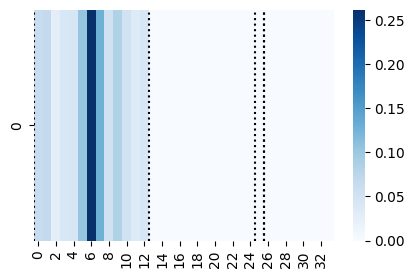

Cutoff 5d
Label 18


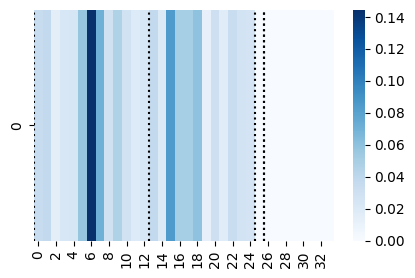

Cutoff 13d
Label 18


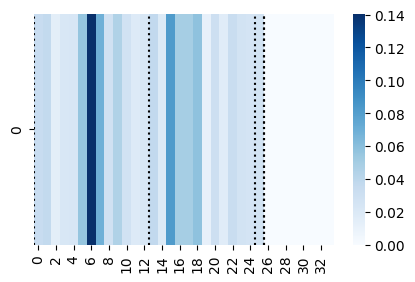

Cutoff noDS
Label 18


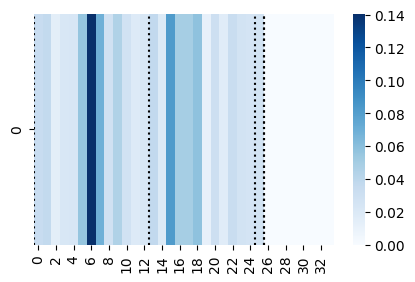

Cutoff all
Label 18


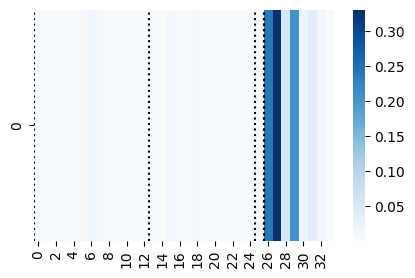

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize a heatmap of attn_output_weights[-1,l,:] for all l in 0,..,49 such that labels[l] == 1
viz_label = 18

for cutoff in cutoffs.keys():
    print(f"Cutoff {cutoff}")
    cutoff_idx = cutoffs[cutoff]   
    print(f"Label {viz_label}")
    plt.figure(figsize=set_size(438.17227, fraction=0.8))
    attn_weights= attn_output_weights[cutoff_idx, viz_label, :].cpu().detach().numpy().reshape(1, -1)
    # make heatmap value range from the min to the max
    sns.heatmap(
        attn_weights,
        cmap="Blues",
        vmin=attn_weights.min(),
        vmax=attn_weights.max(),
    )
    # show lines between the notesº<
    # which are in seq_ids
    # for i in range(1, seq_ids.shape[0]):
    #     if seq_ids[i-1] != seq_ids[i]:
    #         plt.axvline(x=i, color="black")
    # show thin dotted lines at each cutoff
    for cutoff in cutoffs.keys():
        cutoff_idx = cutoffs[cutoff] 
        plt.axvline(x=cutoff_idx+1, color="black", linestyle=":")



    plt.show()


In [116]:
cutoffs

{'2d': 12, '5d': 24, '13d': 25, 'noDS': 25, 'all': -1}

Cutoff 2d
Label 18


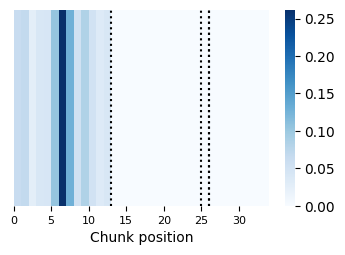

Cutoff 5d
Label 18


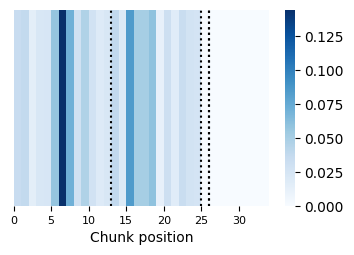

Cutoff 13d
Label 18


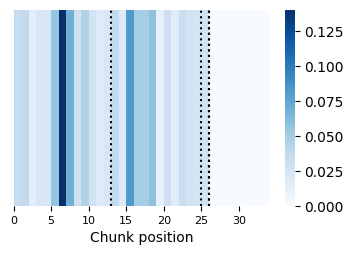

Cutoff noDS
Label 18


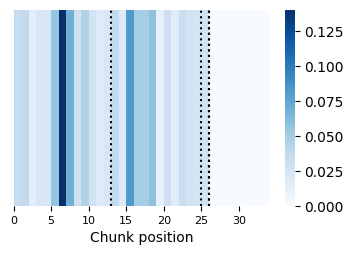

Cutoff all
Label 18


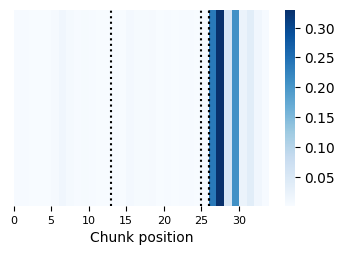

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize a heatmap of attn_output_weights[-1,l,:] for all l in 0,..,49 such that labels[l] == 1
viz_label = 18

for cutoff in cutoffs.keys():
    print(f"Cutoff {cutoff}")
    cutoff_idx = cutoffs[cutoff]   
    print(f"Label {viz_label}")
    plt.figure(figsize=set_size(438.17227, fraction=0.68))
    attn_weights= attn_output_weights[cutoff_idx, viz_label, :].cpu().detach().numpy().reshape(1, -1)
    # make heatmap value range from the min to the max
    sns.heatmap(
        attn_weights,
        cmap="Blues",
        vmin=attn_weights.min(),
        vmax=attn_weights.max(),
    )
    # show lines between the notesº<
    # which are in seq_ids
    # for i in range(1, seq_ids.shape[0]):
    #     if seq_ids[i-1] != seq_ids[i]:
    #         plt.axvline(x=i, color="black")
    # show thin dotted lines at each cutoff
    cutoff_idxs = []
    for cutoffx in cutoffs.keys():
        if cutoffx != 'all':
            cutoff_idx = cutoffs[cutoffx] 
            cutoff_idxs.append(cutoff_idx)
            plt.axvline(x=cutoff_idx+1, color="black", linestyle=":")
    plt.xlabel("Chunk position", fontsize=10)
    # remove y axis ticks
    plt.yticks([])
    # rotate x ticks and place them every 5 ticks
    plt.xticks(list(range(0, attn_weights.shape[1],5)), list(range(0, attn_weights.shape[1],5)), rotation=0,fontsize=8)
    # 
    plt.savefig(f"figures/new_attention_weights_{14}_{viz_label}_{cutoff}.png", bbox_inches="tight")
    plt.show() 


### Quantitative qualitative evaluation

In [2]:
import json
from data.preprocess import DataProcessor
import os
from data.custom_dataset import CustomDataset
from data.utils import get_dataset, get_tokenizer, get_dataloader
from model.model import Model
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import ast
import os
import itertools
import torch.utils.checkpoint
from torch.cuda.amp import GradScaler, autocast
from training.trainer import Trainer
import argparse
from evaluation.evaluate import evaluate
from evaluation.metrics import MyMetrics


run_name = 'Enhancing_MMULA_length_indep_1'

USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")
print(device)

### for debugging use cpu
device = cpu

config = {
    #    "run_name": "Run_test_TLWAN"
    "run_name": run_name,
    "project_path": "/vol/bitbucket/mh1022/temporal-modelling-icd",
}
with open(os.path.join("", f"results/config_{config['run_name']}.json"), "r") as f:
    config = json.load(f)

# process and aggregate raw data
dp = DataProcessor(dataset_path="dataset", config=config)
notes_agg_df, categories_mapping = dp.aggregate_data()

# get tokenizer
tokenizer = get_tokenizer(config["base_checkpoint"])

# Get training / validation / test
dataset_config = {
    "max_chunks": config["max_chunks"],
    "setup": config["setup"],
    "limit_ds": config["limit_ds"],
}

val_set = get_dataset(notes_agg_df, "VALIDATION", tokenizer=tokenizer, **dataset_config)
val_generator = get_dataloader(val_set)

# only to run on CPU
os.environ["TOKENIZERS_PARALLELISM"] = "false"

config["num_categories"] = len(categories_mapping)
model = Model(config, device=device)


# load best model
checkpoint = torch.load(
    os.path.join(
        config["project_path"], f"results/BEST_{config['run_name']}.pth"
    )
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()



def return_attn_scores(lwan, encoding, all_tokens=True, cutoffs=None):
    # encoding: Tensor of size (Nc x T) x H
    # mask: Tensor of size Nn x (Nc x T) x H
    # temporal_encoding = Nn x (N x T) x hidden_size
    T = lwan.seq_len
    if not lwan.all_tokens:
        T = 1  # only use the [CLS]-token representation
    Nc = int(encoding.shape[0] / T)
    H = lwan.hidden_size
    Nl = lwan.num_labels

    # label query: shape L, H
    # encoding: hape NcxT, H
    # query shape:  Nn, L, H
    # key shape: Nn, Nc*T, H
    # values shape: Nn, Nc*T, H
    # key padding mask: Nn, Nc*T (true if ignore)
    # output: N, L, H
    mask = torch.ones(size=(Nc, Nc * T), dtype=torch.bool).to(device=lwan.device)
    for i in range(Nc):
        mask[i, : (i + 1) * T] = False

    # only mask out at 2d, 5d, 13d and no DS to reduce computation
    # get list of cutoff indices from cutoffs dictionary

    attn_output, attn_output_weights = lwan.multiheadattn.forward(
        query=lwan.label_queries.repeat(mask.shape[0], 1, 1),
        key=encoding.repeat(mask.shape[0], 1, 1),
        value=encoding.repeat(mask.shape[0], 1, 1),
        key_padding_mask=mask,
        need_weights=True,
    )

    score = torch.sum(
        attn_output
        * lwan.label_weights.unsqueeze(0).view(
            1, lwan.num_labels, lwan.hidden_size
        ),
        dim=2,
    )
    return attn_output_weights, score

from tqdm import tqdm

weights_per_class = {cutoff: {c: [] for c in range(14)} for cutoff in ["2d", "5d", "13d", "noDS", 'all']}
samples_per_class = {cutoff: {c: [] for c in range(14)} for cutoff in ["2d", "5d", "13d", "noDS", 'all']}

for t in tqdm(range(len(val_set))):
    if t == 2:
        break
    data = val_set[t]
    labels = data["label"][: model.num_labels]
    input_ids = data["input_ids"]
    attention_mask = data["attention_mask"]
    seq_ids = data["seq_ids"]
    category_ids = data["category_ids"]
    avail_docs = seq_ids.max().item() + 1
    # note_end_chunk_ids = data["note_end_chunk_ids"]
    cutoffs = data["cutoffs"]

    complete_sequence_output = []
    inf_chunks = 8
    # run through data in chunks of max_chunks
    for i in range(0, input_ids.shape[0], inf_chunks):
        # only get the document embeddings
        sequence_output = model(
            input_ids=input_ids[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            attention_mask=attention_mask[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            seq_ids=seq_ids[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            category_ids=category_ids[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            cutoffs=None,
            is_evaluation=True,
            # note_end_chunk_ids=note_end_chunk_ids,
        )
        complete_sequence_output.append(sequence_output)
    # concatenate the sequence output
    sequence_output = torch.cat(complete_sequence_output, dim=0)
    attn_output_weights, scores = return_attn_scores(model.label_attn, sequence_output, cutoffs=cutoffs)
    labels_sample = []
    for i in range(50):
        if labels[i] == 1:
            labels_sample.append(i)
    for cutoff in cutoffs.keys():
        cutoff_idx = cutoffs[cutoff]   
        for l in labels_sample:   
            attn_weights= attn_output_weights[cutoff_idx, l, :].cpu().detach().numpy().reshape(1, -1)
            for chunk in range(cutoff_idx+1):
                c = category_ids[chunk].item()
                weights_per_class[cutoff][c].append( attn_output_weights[cutoff_idx, l, chunk].item())   

json.dump(weights_per_class, open("weights_per_class.json",'w'))    

/vol/bitbucket/mh1022/dl_cw_pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


/vol/bitbucket/mh1022/temporal-modelling-icd/data/preprocess.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  self.notes_df = pd.read_csv(os.path.join(dataset_path, "NOTEEVENTS.csv"))


{'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at RoBERTa-base-PM-M3-Voc-hf were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 2/1573 

In [1]:
from tqdm import tqdm

weights_per_class = {cutoff: {c: [] for c in range(14)} for cutoff in ["2d", "5d", "13d", "noDS", 'all']}
samples_per_class = {cutoff: {c: [] for c in range(14)} for cutoff in ["2d", "5d", "13d", "noDS", 'all']}

for t in tqdm(range(len(val_set))):
    data = val_set[t]
    labels = data["label"][: model.num_labels]
    input_ids = data["input_ids"]
    attention_mask = data["attention_mask"]
    seq_ids = data["seq_ids"]
    category_ids = data["category_ids"]
    avail_docs = seq_ids.max().item() + 1
    # note_end_chunk_ids = data["note_end_chunk_ids"]
    cutoffs = data["cutoffs"]

    complete_sequence_output = []
    inf_chunks = 8
    # run through data in chunks of max_chunks
    for i in range(0, input_ids.shape[0], inf_chunks):
        # only get the document embeddings
        sequence_output = model(
            input_ids=input_ids[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            attention_mask=attention_mask[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            seq_ids=seq_ids[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            category_ids=category_ids[i : i + inf_chunks].to(
                device, dtype=torch.long
            ),
            cutoffs=None,
            is_evaluation=True,
            # note_end_chunk_ids=note_end_chunk_ids,
        )
        complete_sequence_output.append(sequence_output)
    # concatenate the sequence output
    sequence_output = torch.cat(complete_sequence_output, dim=0)
    attn_output_weights, scores = return_attn_scores(model.label_attn, sequence_output, cutoffs=cutoffs)
    labels_sample = []
    for i in range(50):
        if labels[i] == 1:
            labels_sample.append(i)
    for cutoff in cutoffs.keys():
        cutoff_idx = cutoffs[cutoff]   
        for l in labels_sample:   
            attn_weights= attn_output_weights[cutoff_idx, l, :].cpu().detach().numpy().reshape(1, -1)
            for chunk in range(cutoff_idx+1):
                c = category_ids[chunk].item()
                weights_per_class[cutoff][c].append( attn_output_weights[cutoff_idx, l, chunk].item())   
    # for cutoff in cutoffs.keys():
    #     cutoff_idx = cutoffs[cutoff]   
    #     for l in labels_sample:   
    #         attn_weights= attn_output_weights[cutoff_idx, l, :].cpu().detach().numpy().reshape(1, -1)
    #         class_weights = {i: 0 for i in range(14)}
    #         class_samples = {i: 0 for i in range(14)}
    #         for chunk in range(cutoff_idx+1):
    #             category = category_ids[chunk].item()
    #             class_weights[category] += attn_weights[0, chunk]
    #             class_samples[category] += 1
    #         for c in class_weights.keys():
    #             weights_per_class[cutoff][c].append(class_weights[c])      
    #             samples_per_class[cutoff][c].append(class_samples[c])    
json.dump(weights_per_class, open("weights_per_class.json",'w'))      

NameError: name 'val_set' is not defined

In [18]:
weights_per_class['5d']

{'0': [],
 '1': [0.1157711073756218,
  0.0840199813246727,
  0.1543574333190918,
  0.11422178149223328,
  0.05803873389959335,
  0.003391614882275462,
  0.0026653024833649397,
  0.005190757103264332,
  0.0030643551144748926,
  0.0026323834899812937,
  0.004418328870087862,
  0.00047644629376009107,
  0.00031869192025624216,
  0.0008255919092334807,
  0.00043590940185822546,
  0.0003069379017688334,
  0.0005787045229226351,
  0.24721759557724,
  0.2508111894130707,
  0.3814929127693176,
  0.3558909595012665,
  0.3703845143318176,
  0.3765805661678314,
  0.4314285218715668,
  0.3996445834636688,
  0.08658529818058014,
  0.06044435128569603,
  0.08779282122850418,
  0.11243267357349396,
  0.28232789039611816,
  0.07807228714227676,
  0.14814241230487823,
  0.023830784484744072,
  0.1868358850479126,
  0.05481811612844467,
  0.22713394463062286,
  0.04282737523317337,
  0.2726266086101532,
  0.006451328285038471,
  0.30282002687454224,
  0.0179162435233593,
  0.045567359775304794,
  0.0085

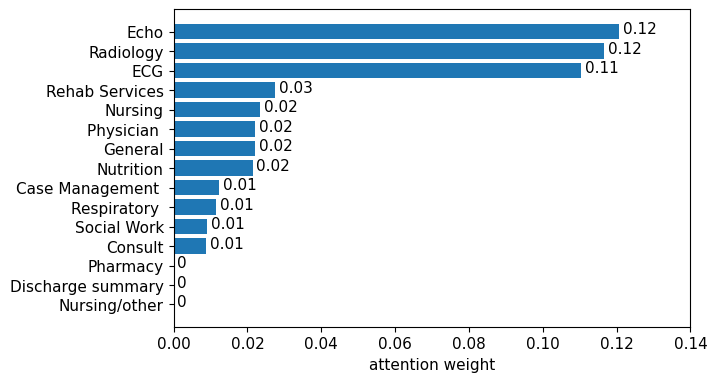

In [47]:
# plot avg and std weights per class for each cutoff

# 2d cutoff
# make plot showing avg and std weights per class (bar plot)
import json
import matplotlib.pyplot as plt
import numpy as np

weights_per_class = json.load(open("weights_per_class_3.json",'r'))
plt.figure(figsize=set_size(438.17227, fraction=1.1))
plt.ylabel("avg weight")
plt.xlabel("class")
name_mapping= {'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}
num_to_name = {v: k for k, v in name_mapping.items()}
avgs = [np.mean(weights_per_class['2d'][str(c)]) if len(weights_per_class['2d'][str(c)]) > 0 else 0 for c in range(15)]
# show the bars horizontally and order them by avg weight
sorted_idx = np.argsort(avgs)
avgs = [avgs[i] for i in sorted_idx]
plt.barh(list(range(15)),avgs)
plt.yticks(list(range(15)), [num_to_name[c] for c in sorted_idx], rotation=0, fontsize=11)
plt.ylabel(None)
plt.xlabel("attention weight", fontsize=11)
# increase x range
plt.xlim(0, 0.14)
plt.xticks(fontsize=11)
# show values on top of bars
for i, v in enumerate(avgs):
    plt.text(v + 0.001, i - 0.1, str(round(v, 2)), color='black', fontsize=11)
# show also number of samples
#in a separate bar on the same plot
plt.savefig("figures/avg_weights_2d.png", bbox_inches="tight")

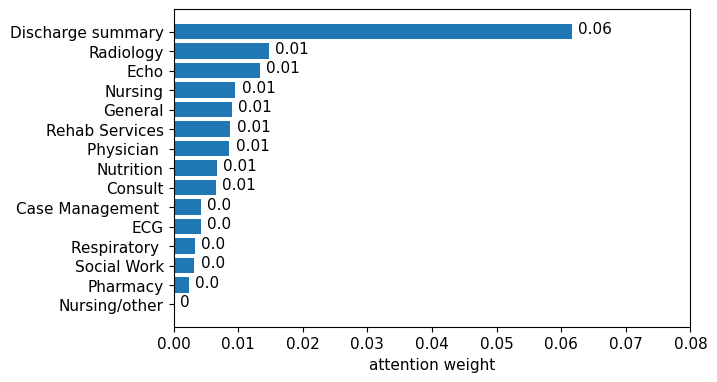

In [124]:
# plot avg and std weights per class for each cutoff

# 2d cutoff
# make plot showing avg and std weights per class (bar plot)
import json
import matplotlib.pyplot as plt
import numpy as np

weights_per_class = json.load(open("weights_per_class_3.json",'r'))
plt.figure(figsize=set_size(438.17227, fraction=1.1))
plt.ylabel("avg weight")
plt.xlabel("class")
name_mapping= {'Nursing/other': 0, 'Radiology': 1, 'Nursing': 2, 'Physician ': 3, 'ECG': 4, 'Discharge summary': 5, 'Respiratory ': 6, 'Echo': 7, 'Nutrition': 8, 'General': 9, 'Rehab Services': 10, 'Social Work': 11, 'Case Management ': 12, 'Consult': 13, 'Pharmacy': 14}
num_to_name = {v: k for k, v in name_mapping.items()}
avgs = [np.mean(weights_per_class['all'][str(c)]) if len(weights_per_class['all'][str(c)]) > 0 else 0 for c in range(15)]
# show the bars horizontally and order them by avg weight
sorted_idx = np.argsort(avgs)
avgs = [avgs[i] for i in sorted_idx]
plt.barh(list(range(15)),avgs)
plt.yticks(list(range(15)), [num_to_name[c] for c in sorted_idx], rotation=0, fontsize=11)
plt.ylabel(None)
plt.xlabel("attention weight", fontsize=11)
# increase x range
plt.xlim(0, 0.08)
plt.xticks(fontsize=11)
# show values on top of bars
for i, v in enumerate(avgs):
    plt.text(v + 0.001, i - 0.1, str(round(v, 2)), color='black', fontsize=11)
# show also number of samples
#in a separate bar on the same plot
plt.savefig("figures/avg_weights_DS.png", bbox_inches="tight")


In [66]:
weights_per_class

{'2d': {0: [],
  1: [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  2: [],
  3: [],
  4: [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
